In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import json

with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photometry_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

# Prepare data
X = df[spectro_cols + photometry_cols + generic_cols].copy()
y = df[target_col].copy()
X.fillna(X.median(), inplace=True)

# Normalize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [2]:
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'tree_method': 'hist',  # Fast histogram-based algorithm
    'num_parallel_tree': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'max_depth': 6,
    'learning_rate': 1.0,  # Set to 1.0 for random forest mode
    'nthread': 4,
    'seed': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train using num_boost_round = 1 to prevent boosting
model_rf = xgb.train(params, dtrain, num_boost_round=1)

# Predict
y_pred = model_rf.predict(dval)

# Evaluate
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"XGBoost Random Forest MAE: {mae:.3f}")
print(f"XGBoost Random Forest R²: {r2:.3f}")


XGBoost Random Forest MAE: 0.135
XGBoost Random Forest R²: 0.908


In [3]:
import shap

# SHAP TreeExplainer (optimized for XGBoost)
explainer = shap.Explainer(model_rf)

# Compute SHAP values for validation set
shap_values = explainer(X_val)


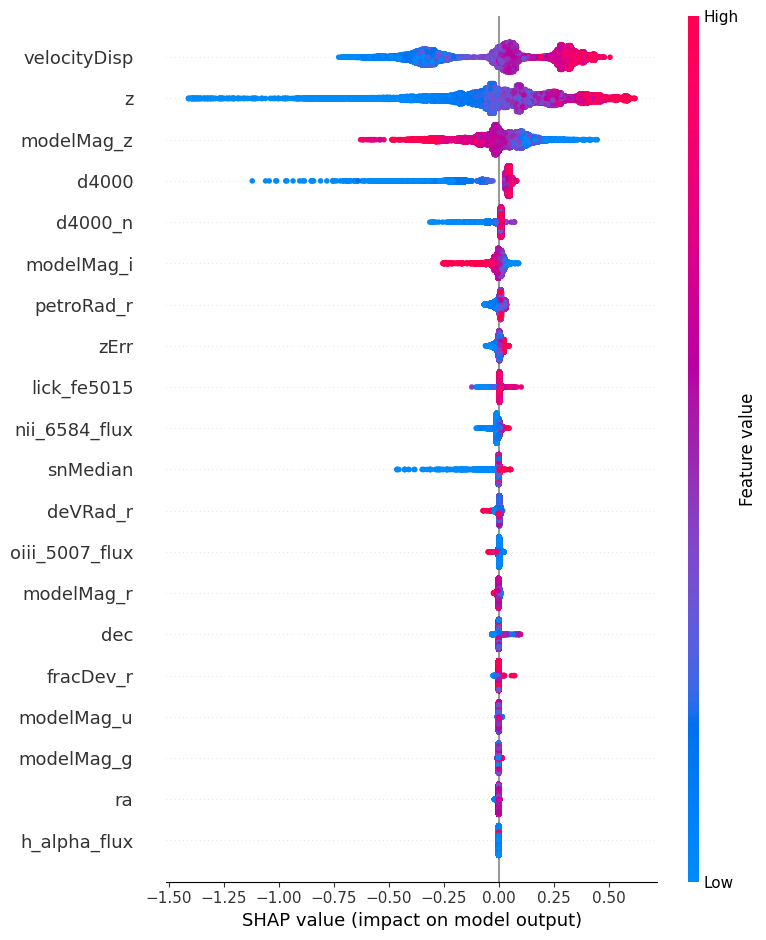

In [4]:
shap.summary_plot(shap_values, X_val, feature_names=X.columns)


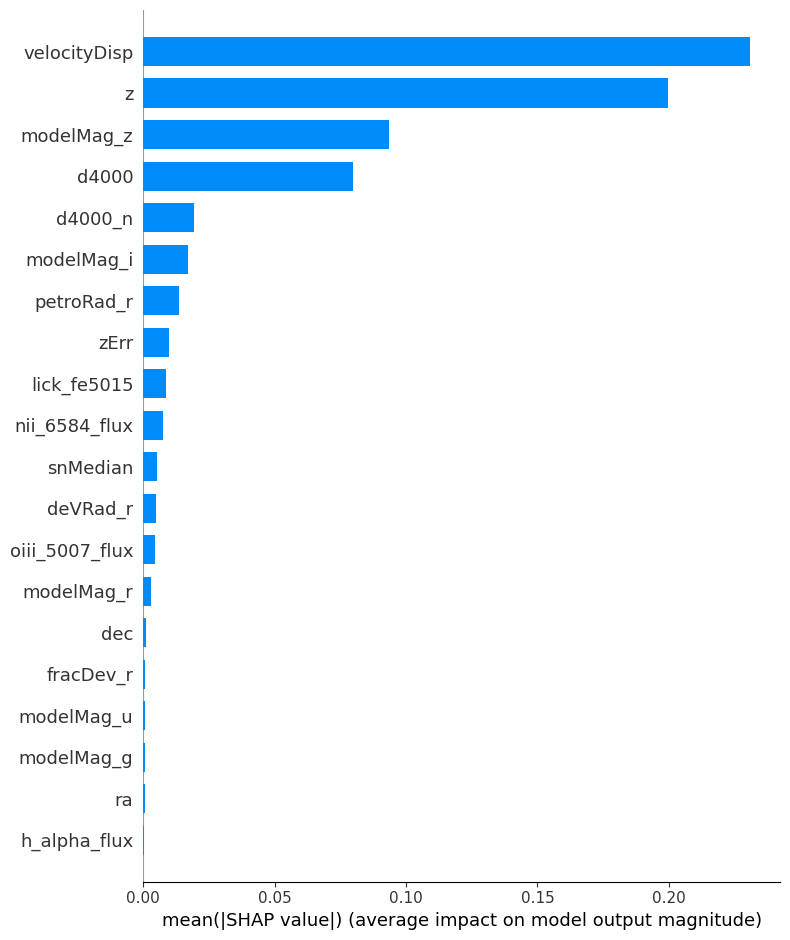

In [5]:
shap.summary_plot(shap_values, X_val, feature_names=X.columns, plot_type="bar")


In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=X.columns.tolist())


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_visuals(y_test, y_pred, z_values=None):
    # Convert to numpy arrays and flatten
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()

    if z_values is not None:
        z_values = np.array(z_values).flatten()

    residuals = y_test - y_pred

    # Residual Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_pred,
            residuals,
            c=z_values,
            cmap='viridis',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot (Colored by Redshift)" if z_values is not None else "Residual Plot")
    plt.tight_layout()
    plt.show()

    # Parity Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_test,
            y_pred,
            c=z_values,
            cmap='plasma',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Parity Plot (Colored by Redshift)" if z_values is not None else "Parity Plot")
    plt.tight_layout()
    plt.show()

    # Residual Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Distribution of Prediction Errors")
    plt.tight_layout()
    plt.show()


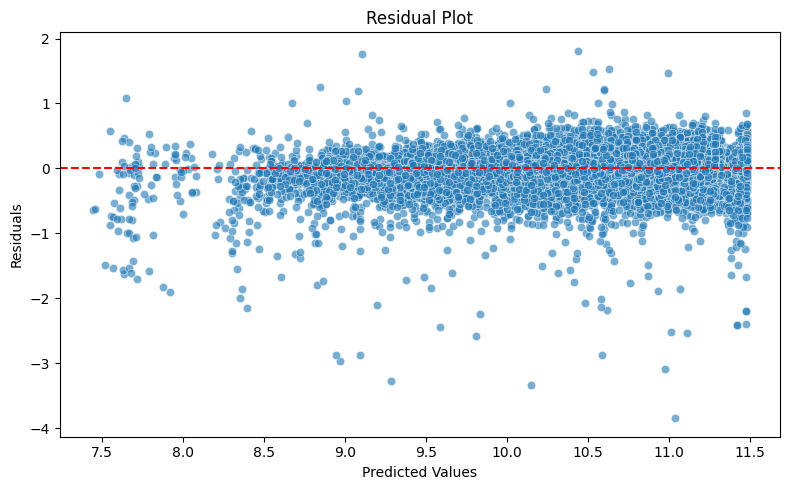

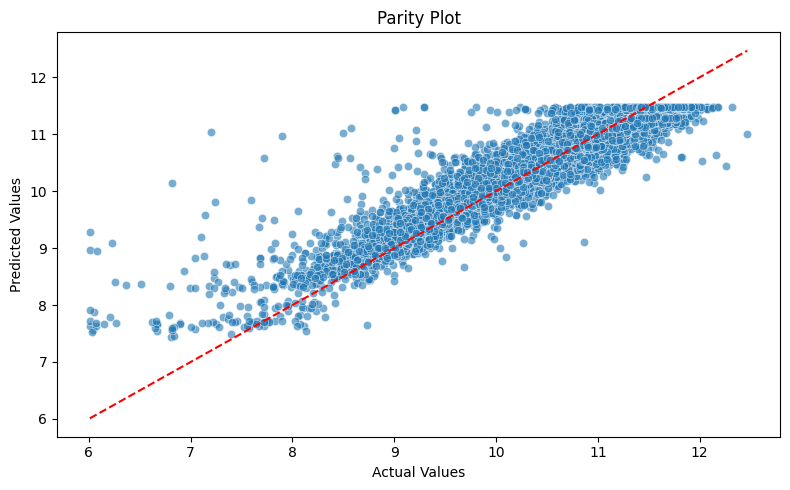

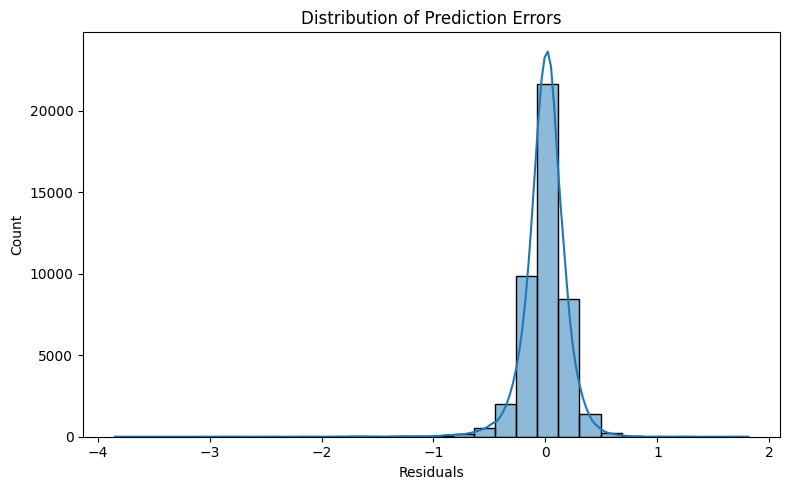

In [10]:
plot_visuals(y_val, y_pred)